In [1]:
import sys
from cytoemd import CytoEMD
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import umap

from sklearn.metrics import (
    roc_curve, auc
)

from collections import OrderedDict, defaultdict
from anndata import read_h5ad, AnnData

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Read the data and perform pre-processing

In [2]:
adata = read_h5ad("../data/anti_pd_base_23.h5ad")
marker_in_use = ['Bi209Di', 'Dy162Di', 'Dy163Di', 'Er166Di', 'Er167Di', 'Eu151Di', 'Eu153Di', 'Gd152Di', 'Gd155Di',
                 'Gd156Di', 'Gd160Di', 'Ho165Di', 'Lu175Di', 'Nd142Di', 'Nd146Di', 'Sm147Di', 'Sm148Di', 'Sm149Di',
                 'Sm150Di', 'Tm169Di', 'Y89Di', 'Yb170Di', 'Yb173Di', 'Yb174Di']
adata.var.index = adata.var['pnn_label']
adata.var.index.name = 'index'
adata = adata[:,marker_in_use]

co_factor = 5.
# set seed for reproducibility
seed = 0

adata.X = np.arcsinh(adata.X / co_factor)

In [3]:
adata.obs.head()

,filename,condition,shortname,patient_id,color,time
1-1,BASE_CK_2016-06-23_03_NR1.fcs,base_NR,base_NR1,6,#CC79A7,2016-06-23
1-2,BASE_CK_2016-06-23_03_NR1.fcs,base_NR,base_NR1,6,#CC79A7,2016-06-23
1-3,BASE_CK_2016-06-23_03_NR1.fcs,base_NR,base_NR1,6,#CC79A7,2016-06-23
1-4,BASE_CK_2016-06-23_03_NR1.fcs,base_NR,base_NR1,6,#CC79A7,2016-06-23
1-5,BASE_CK_2016-06-23_03_NR1.fcs,base_NR,base_NR1,6,#CC79A7,2016-06-23


In [4]:
adata_list = [adata[adata.obs['filename'] == sample, :] for sample in adata.obs['filename'].unique()]
for x in adata_list:
    x.var.index = x.var['Antigen']
sample_meta_list = [_adata.obs[['filename', 'condition', 'shortname']].iloc[0].T for _adata in adata_list]
sample_meta = pd.concat(sample_meta_list, axis=1).T

### Create the model and fit the data

In [5]:
%%time
model = CytoEMD(emd_type='UMAP', random_state=1, use_fast=True, n_cpus=4)
embeddings = model.fit_transform(adata_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 186.44it/s]


CPU times: user 3.39 s, sys: 40 ms, total: 3.43 s
Wall time: 3.65 s


### Umap of different samples

... storing 'condition' as categorical


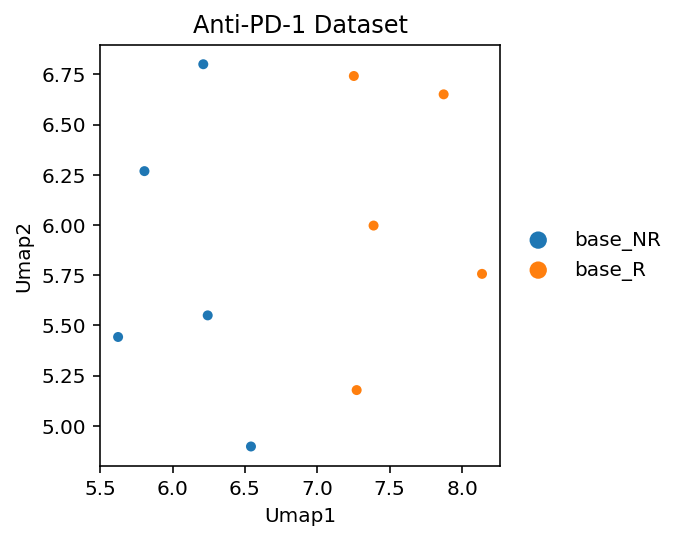

In [6]:
sample_adata = AnnData(embeddings, obs=sample_meta, var=pd.DataFrame(index=['Umap1', 'Umap2']))
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.scatter(sample_adata, x='Umap1', y='Umap2', color='condition', title='Anti-PD-1 Dataset', size=100)
sample_adata.write("../results/antipd_cytoemd.h5ad", compression='gzip')

In [7]:
# prepare the params of meld
sample_labels = np.array(sample_meta['condition'].tolist())
meld_kwargs = {'beta': 10, 'sample_normalize': True, 'knn': 4}

# predict the predicted under the phenotype (normalized to 1)
pred_prob = model.predict_prob(embeddings, sample_labels, meld_kwargs)
pred_prob.head()

Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


,base_NR,base_R
0,0.549935,0.450065
1,0.568372,0.431628
2,0.609080,0.390920
3,0.621679,0.378321
4,0.603713,0.396287


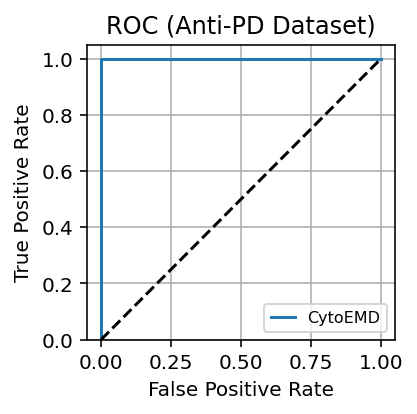

In [8]:
### Plot the ROC Curve
fpr, tpr, thres = roc_curve(
    sample_labels, pred_prob['base_NR'], pos_label='base_NR'
)
auc_score = auc(fpr, tpr)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(fpr, tpr, '-', label='CytoEMD')
ax.plot([0,1], [0,1], 'k--')

ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=10)
ax.set_ylabel("True Positive Rate", fontsize=10)
ax.set_title('ROC (Anti-PD Dataset)', fontsize=12)
ax.grid(":")
ax.legend(loc='best', handlelength=1.5, fontsize=8)
plt.tight_layout()
plt.show()

### Rank the markers using entropy score

In [9]:
# calculate the ce score for each marker
ce_score = model.rank_markers(adata_list, sample_labels, meld_kwargs=meld_kwargs)
### sort the cross entropy score
ce_score = OrderedDict(sorted(ce_score.items(), key=lambda x: x[1]))
# print ce_score (lower is more significant)
print(ce_score)

Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

In [10]:
### create data frame
ce_df = defaultdict(list)
for k, v in ce_score.items():
    ce_df['Marker'].append(k)
    ce_df['Cross Entropy Score'].append(v)
ce_df = pd.DataFrame(ce_df)

In [11]:
ce_df.head()

,Marker,Cross Entropy Score
0,CD11b,0.388984
1,HLA-DR,0.424385
2,CD274_PDL1,0.446067
3,CD33,0.484449
4,CD123,0.499243


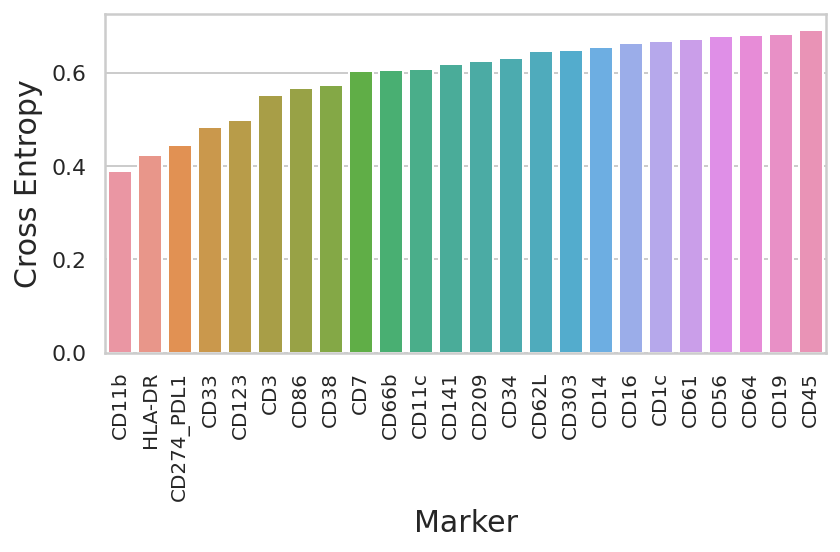

In [12]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Marker", y='Cross Entropy Score', data=ce_df)

ax.set_xlabel("Marker", fontsize=15)
ax.set_ylabel("Cross Entropy", fontsize=15)
ax.set_xticklabels(ce_df['Marker'], rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

### Rank the marker pairs using entropy score

In [13]:
# calculate the ce score for each marker pair
ce_score_pair = model.rank_markers(adata_list, sample_labels, eval_pair=True, meld_kwargs=meld_kwargs)
### sort the cross entropy score
ce_score_pair = OrderedDict(sorted(ce_score_pair.items(), key=lambda x: x[1]))

Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusi

Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples a

Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 10 samples and 2 features.
Calculating graph and diffusi

In [14]:
### create data frame
ce_pair_df = defaultdict(list)
for k, v in ce_score_pair.items():
    ce_pair_df['Marker'].append(k)
    ce_pair_df['Cross Entropy Score'].append(v)
ce_pair_df = pd.DataFrame(ce_pair_df)

In [15]:
ce_pair_df.head()

,Marker,Cross Entropy Score
0,CD11b-CD7,0.273608
1,CD11b-CD16,0.282426
2,CD303-HLA-DR,0.298236
3,CD11b-HLA-DR,0.309392
4,CD11b-CD303,0.325803


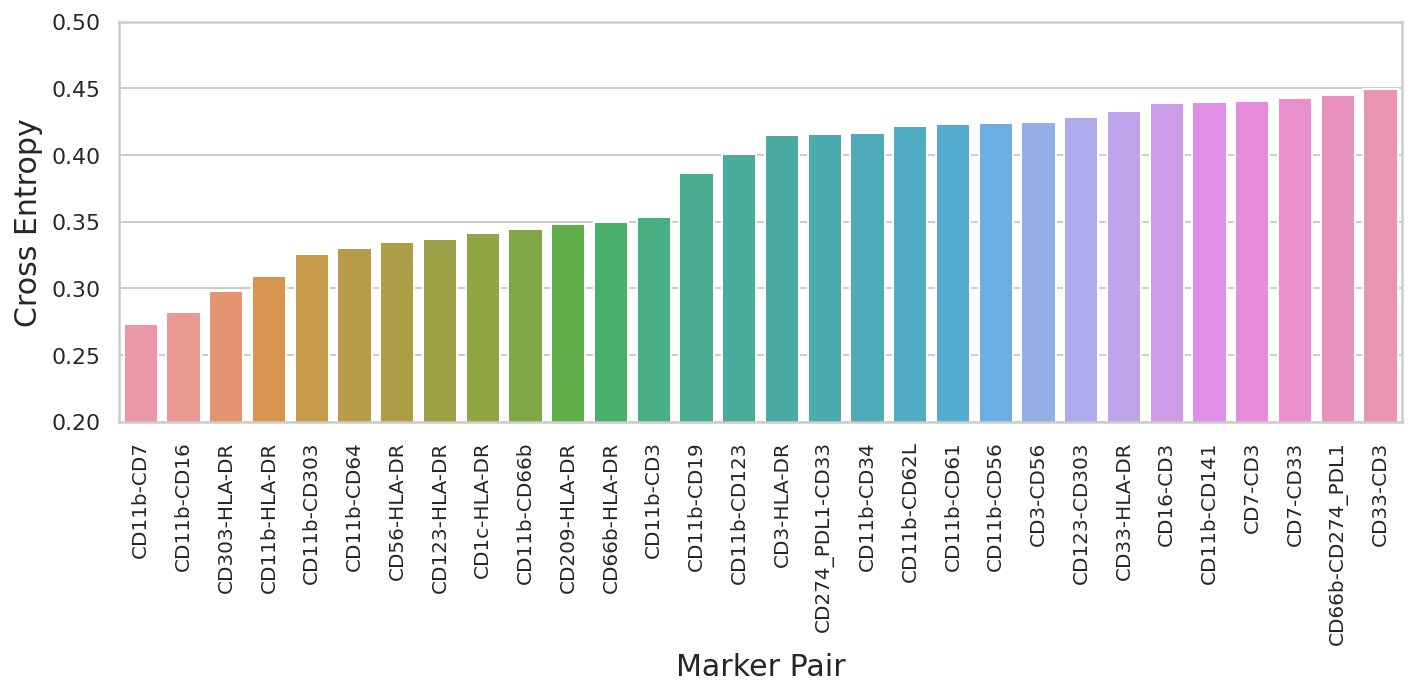

In [16]:
# plot the top 20 marker pairs used to infer cell populations
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.barplot(x="Marker", y='Cross Entropy Score', data=ce_pair_df.iloc[:30,:], ax=ax)

ax.set_ylim([0.2, 0.5])
ax.set_xlabel("Marker Pair", fontsize=15)
ax.set_ylabel("Cross Entropy", fontsize=15)
ax.set_xticklabels(ce_pair_df['Marker'][:30], rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

<AxesSubplot:>

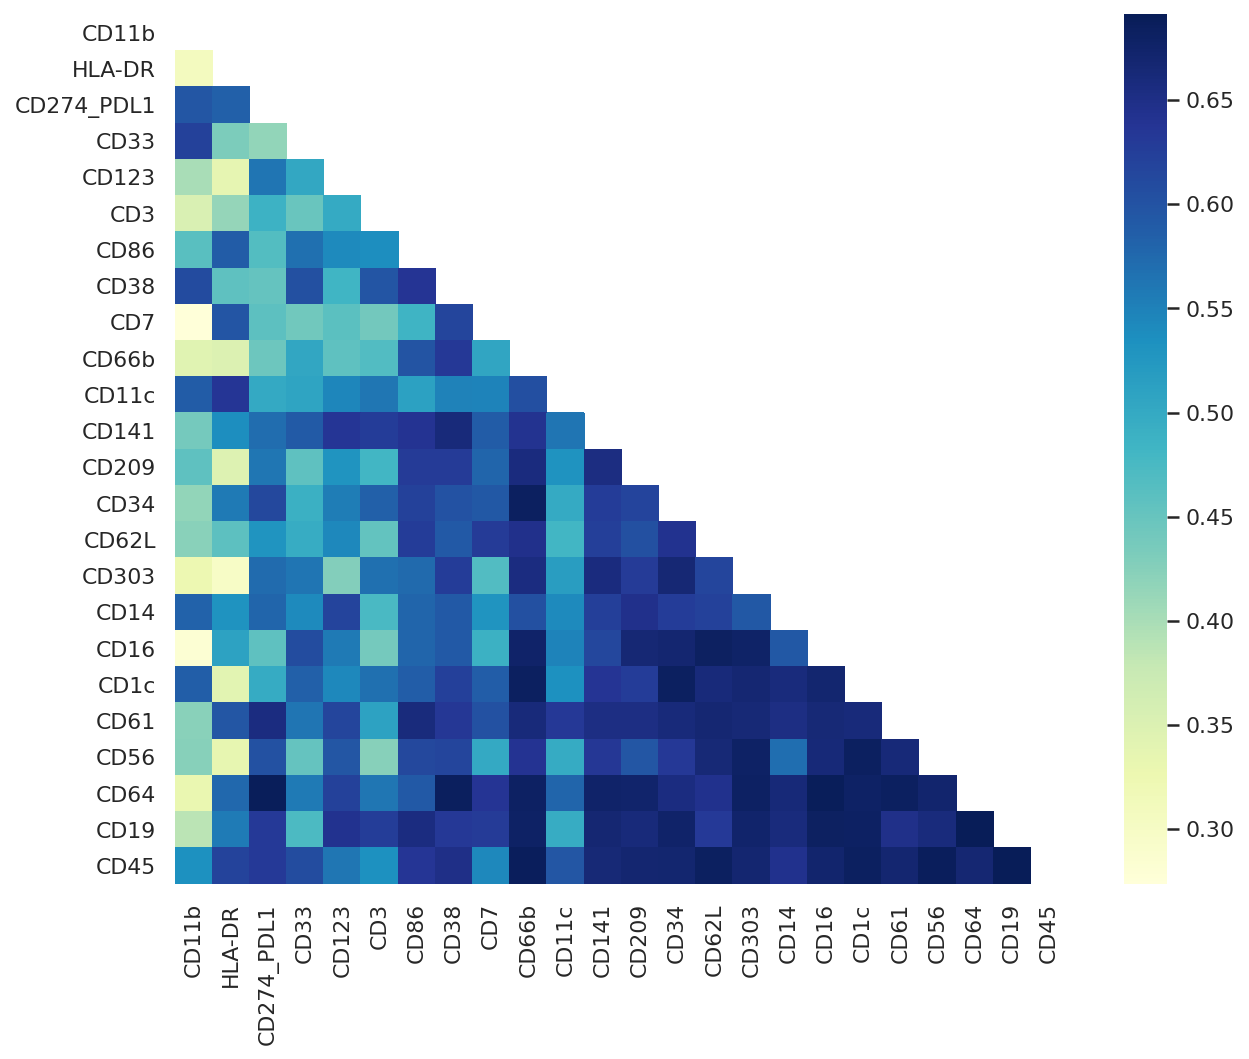

In [17]:
import seaborn as sns
from itertools import combinations

marker_list = list(ce_score.keys())
score_mtx = np.zeros((len(marker_list), len(marker_list)))
mask = np.zeros_like(score_mtx)
mask[np.triu_indices_from(mask)] = True

for m1, m2 in combinations(marker_list, r=2):
    i1, i2 = marker_list.index(m1), marker_list.index(m2)
    k = '-'.join([m1, m2])
    if k in ce_score_pair.keys():
        score_mtx[i1, i2] = ce_score_pair[k]
        score_mtx[i2, i1] = ce_score_pair[k]
    else:
        k = '-'.join([m2, m1])
        score_mtx[i1, i2] = ce_score_pair[k]
        score_mtx[i2, i1] = ce_score_pair[k]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(score_mtx, mask=mask, annot=False, fmt='g', ax=ax,
            cmap='YlGnBu', yticklabels = marker_list, xticklabels = marker_list)
# ax.set_title('Cross Entropy Score Matrix')